In [456]:
#install.packages("readxl")
library(tidyverse)
library(rvest)
library(readxl)
install.packages("reshape2")
library(reshape2)

options(repr.plot.width=15, repr.plot.height=15, repr.plot.pointsize=1000) # Setting plot size as a global option.

base_theme <- theme(plot.title=element_text(size=30), # Setting a default size for all text in our plots.
                    axis.title=element_text(size=30),
                    axis.text.x=element_text(size=15),
                    axis.text.y=element_text(size=15),
                    legend.title=element_text(size=25),
                    legend.text=element_text(size=20)) 





The downloaded binary packages are in
	/var/folders/xk/xq0cwh3n7fz7v_0827s1pq400000gn/T//RtmpmVRcLQ/downloaded_packages



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [98]:
#first we get all xlsx file links from url
mental_health_data_urls_all_years <- 'https://www.health.govt.nz/our-work/mental-health-and-addiction/mental-health-and-addiction-monitoring-reporting-and-data' %>% 
                                        read_html() %>%
                                        html_element('#node-12245 > div > div > div > ul:nth-child(19)') %>%
                                        html_elements("a") %>%
                                        html_attrs() %>% 
                                        str_c('https://www.health.govt.nz/', .)

#function is to download xlsx from health url 
download_xlsx_file <- function(heath_url, file_name){
                        download_ur <- heath_url %>% 
                            read_html() %>%
                            html_element("#block-system-main > div > div:nth-child(2) > div.panel-panel.right.col-xs-12.col-sm-12.col-md-3.col-lg-3 > div.panel-pane.pane-views.pane-file-attachments-revisioning.pane-downloads-right.standard-block.even.hidden-xs.hidden-sm > div > div > div > div > ul > li > span > a") %>% 
                            html_attr("href") 
                        download.file(url = download_ur, destfile = file_name)
}


build_sheet_name <- function(str1, str2, separator){
    data <- paste(str1, str2, sep=separator)
    return(data)
}

get_sheet_separator <- function(file_name){
    sheets <- file_name %>% excel_sheets()
    if ('table1,2' %in% sheets){
        separator <- ','
    }else{
        separator <- '&'
    }
}


#iteral through every year from 2014 to 2019
file_metadata_df <- data.frame(year=double(),
                               file_name=character(),
                               url=character(),
                               separator=character())

start_year = 2014

for (url_yearly_health in mental_health_data_urls_all_years){
    file_name = str_c('mental_health', start_year) %>% 
                    str_c('.xlsx')
    start_year = start_year + 1
    print(url_yearly_health)
    download_xlsx_file(url_yearly_health, file_name)
    separator <- get_sheet_separator(file_name)
    file_metadata_df <- file_metadata_df %>% add_row(year=start_year-1,
                                                 file_name=file_name,
                                                 url=url_yearly_health,
                                                 separator=separator)
}
#we add some custom years to the list
file_metadata_df <- file_metadata_df %>% add_row(year=2011:2013, 
                                                 file_name=c('mental_health2011.xlsx', 'mental_health2012.xlsx', 'mental_health2013.xlsx'),
                                                 url=NA,
                                                 separator='&')

file_metadata_df

[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2019-20-tables"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2018-19-tables"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2017-18-tables"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2014-15"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2013-14"


year,file_name,url,separator
<dbl>,<chr>,<chr>,<chr>
2014,mental_health2014.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2019-20-tables,","
2015,mental_health2015.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2018-19-tables,","
2016,mental_health2016.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2017-18-tables,","
2017,mental_health2017.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables,","
2018,mental_health2018.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables,","
2019,mental_health2019.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2014-15,&
2020,mental_health2020.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2013-14,&
2011,mental_health2011.xlsx,NA,&
2012,mental_health2012.xlsx,NA,&


In [99]:
#get all col names for table use after
#get metadata from one of the files.
first_file = file_metadata_df[1,]

age_group_col_names <-  first_file$file_name %>% read_excel(sheet = build_sheet_name('table1', '2', first_file$separator),
                                                            range = cell_rows(4:4)) %>% colnames()
add_sex_totl_age_group_col_names <- c('gender', "Total", age_group_col_names)


table_1_2_positions <- tibble(ethnic_group=c('Maori', 'Pacific', 'Asian', 'Other'),
                              range=c('B9:U10', 'B12:U13', 'B15:U16', 'B18:U19'))


In [100]:
# 2010 File is different to every other file, so we need a different parser for it.

file_2010 <- "mental_health2010.xls"


get_2010_dfs <- function(file, sheet, range, target_gender, target_ethtnic_group, age_group){
    csv_file_read <- file %>% read_excel(sheet = sheet, range=range)
    colnames(csv_file_read) <- c('amount')
    csv_file_read <- csv_file_read %>% 
                     mutate(gender=target_gender, ethnic_group= target_ethtnic_group) %>% 
                     cbind(age_group)
    return(csv_file_read)
}

client_ages_group_2010 <- file_2010 %>% read_excel(sheet = "T7 Nos Rates 0910 EthSexAge",  range='A4:A22') 
colnames(client_ages_group_2010) <- c('age_group')

data_2010_clients <- get_2010_dfs(file_2010, "T7 Nos Rates 0910 EthSexAge", 'B4:B22', 'Male', 'Maori', client_ages_group_2010 ) %>% 
                        rbind(get_2010_dfs(file_2010, "T7 Nos Rates 0910 EthSexAge", 'D4:D22', 'Female', 'Maori', client_ages_group_2010 )) %>% 
                        rbind(get_2010_dfs(file_2010, "T7 Nos Rates 0910 EthSexAge", 'H4:H22', 'Male', 'Unknown', client_ages_group_2010 )) %>% 
                        rbind(get_2010_dfs(file_2010, "T7 Nos Rates 0910 EthSexAge", 'H4:H22', 'Female', 'Unknown', client_ages_group_2010 )) %>% 
                        mutate('year'=2010)


New names:
* `` -> ...1



In [101]:
#two different way get first table of total group data

clients_by_age_ethnic_group_df <- data.frame(year=double(),
                                         gender=character(), 
                                         ethnic_group=character(),
                                         age_group=character(),
                                         amount=integer() 
                                         ) 


get_clients_by_gender_ethnic_group <- function(file_metadata, columns){

    clients_by_age_ethnic_group <- data.frame(year=double(),
                                         gender=character(), 
                                         ethnic_group=character(),
                                         age_group=character(),
                                         amount=integer()) 
    
    for (i in 1:nrow(table_1_2_positions)) {
        row <- table_1_2_positions[i,]
        if (file_metadata$year == '2011'){
            sheet <- 'Table1'
        }else if(file_metadata$year == '2012'){
            sheet <- 'table1'
        }else{
            sheet <- build_sheet_name("table1", "2", file_metadata$separator)
        }
        ethnic_group_df <- file_metadata$file_name %>% read_excel(sheet=sheet,
                                                       range = row$range,
                                                       col_names = add_sex_totl_age_group_col_names) #range = cell_rows(3:19), 
        ethnic_group_df <- ethnic_group_df %>% add_column(ethnic_group=row$ethnic_group, year=file_metadata$year)
        ethnic_group_df <- ethnic_group_df %>% select(-Total)
        long_col_name <- ethnic_group_df %>% select(ends_with("-"), ends_with('+')) %>% names()
        clients_by_age_ethnic_group <- clients_by_age_ethnic_group %>% 
                                       add_row(ethnic_group_df %>% 
                                       gather(age_group, amount, long_col_name, factor_key=TRUE))
    }  
    return(clients_by_age_ethnic_group)
}

get_all_year_clients_by_gender_ethnic_group <- function(){
    for (i in 1:nrow(file_metadata_df )){
        row <- file_metadata_df[i,]
        clients_by_age_ethnic_group_df <- clients_by_age_ethnic_group_df %>% add_row(get_clients_by_gender_ethnic_group(row, add_sex_totl_age_group_col_names))
    }
    return(clients_by_age_ethnic_group_df) 
    
}



In [102]:
full_clients_by_gender_ethnic_df <- get_all_year_clients_by_gender_ethnic_group()
full_clients_by_gender_ethnic_df %>% sample_n(10)

year,gender,ethnic_group,age_group,amount
<dbl>,<chr>,<chr>,<chr>,<dbl>
2014,Female,Other,0-,357
2013,Male,Maori,85+,9
2014,Female,Other,5-,1736
2011,Female,Maori,65-,138
2012,Female,Maori,65-,148
2016,Female,Pacific,70-,54
2016,Male,Other,85+,825
2016,Female,Maori,25-,2794
2012,Male,Asian,80-,15


In [103]:
# lets get the years outside of the norm
#make all df 2002-2007 data tidy

get_df_tidy <- function(df, year_num){
    #get num of row
    n_row_age_sheeta1 <- nrow(df)
    #set all na values with activity type 
    for (row_num in 1:n_row_age_sheeta1){
        if(df$ethnic_group[[row_num]] %>% is.na()){
            df$ethnic_group[[row_num]] = df$ethnic_group[[row_num - 1]]
        }
    }
    result <- df %>% 
                filter(gender!='NA') %>% 
                gather(age_group, amount, -c(ethnic_group,gender,amount)) %>% 
                mutate('year'=year_num) 
    result <- result %>% filter(gender!='Total') %>% filter(ethnic_group!='Total')
    result <- result[,c(5,2,1,3,4)]
    return(result)
}

#get 2002/2005 data

file_metadata_2001_2007 <- tibble(year=2002:2008,
                                  sheet=c('A1', 'A1', 'A1', 'A1', '1A', '1B', 'A1'),
                                  range=c('A5:U25', 'A4:U24', 'A5:U26', 'A5:U25', 'A5:U26', 'A5:U26', 'A5:U25'),
                                  titles=c('D5:U5', 'D4:U4', 'D5:U5', 'D5:U5', 'D5:U5', 'D5:U5', 'D5:U25')
                                 )

get_2001_2007_file_df <- function(file_name, year_num){
    print(year_num)
    file_metadata <- file_metadata_2001_2007 %>% filter(year==year_num)
    #get client age group names
    client_ages_sheeta1 <- file_name %>% read_excel(sheet = file_metadata$sheet, range=file_metadata$titles) %>% colnames()
    col_names_seen_by_age_sheeta1  <- c('ethnic_group', 'gender', 'amount', client_ages_sheeta1)
    
    #get data from the file rename with names before
    client_seen_by_age_data_a1 <-  file_name %>% read_excel(sheet=file_metadata$sheet, range=file_metadata$range)
    colnames(client_seen_by_age_data_a1) <- col_names_seen_by_age_sheeta1 

    return(get_df_tidy(client_seen_by_age_data_a1, year_num))
}

get_all_a1sheet_2002_2007_df <- function(){
    
    result <- get_2001_2007_file_df('mental_health2002.xls',2002) %>% 
             rbind(get_2001_2007_file_df('mental_health2003.xls',2003)) %>% 
             rbind(get_2001_2007_file_df('mental_health2004.xls',2004)) %>% 
             rbind(get_2001_2007_file_df('mental_health2005.xls',2005)) %>% 
             rbind(get_2001_2007_file_df('mental_health2006.xls',2006)) %>% 
             rbind(get_2001_2007_file_df('mental_health2007.xls',2007)) %>% 
             rbind(get_2001_2007_file_df('mental_health2008.xls',2008)) 


    return(result)
}

#year from 2002-2007, 2010-2019
full_clients_by_gender_ethnic_df <- full_clients_by_gender_ethnic_df %>% 
                                    rbind(get_all_a1sheet_2002_2007_df()) %>%  
                                    rbind(data_2010_clients) %>%
                                    arrange(year) %>% 
                                    filter(gender!='Total') %>%
                                    filter(ethnic_group!='Total') 


[1] 2002


New names:
* `` -> ...1
* `` -> ...2



[1] 2003


New names:
* `` -> ...1
* `` -> ...2



[1] 2004


New names:
* `` -> ...1
* `` -> ...2



[1] 2005


New names:
* `` -> ...1
* `` -> ...2



[1] 2006


New names:
* `` -> ...1
* `` -> ...2



[1] 2007


New names:
* `` -> ...1
* `` -> ...2



[1] 2008


New names:
* `` -> ...1
* `` -> ...2



In [104]:
#full_clients_by_gender_ethnic_df <- full_clients_by_gender_ethnic_df %>% rbind(get_2001_2007_file_df('mental_health2006.xls',2006))

In [105]:
#lets clean this dataframe a little
full_clients_by_gender_ethnic_df <- full_clients_by_gender_ethnic_df %>% mutate(ethnic_group=gsub("Māori", "Maori", ethnic_group))


start <- c("0-4", "0-5","5-9","10-14","15-19","20-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-64","65-69","70-74","75-79","80-84",'85+')
end <- c("5-", "5-","10-","15-","20-","25-","30-","35-","40-","45-","50-","55-","60-","65-","70-","75-","80-","85+",'85+')
age_group_tibble <- tibble(start=start, end=end)

replace_age_group <- function(value){
    
  replace <- age_group_tibble %>% filter(start==value)
  if (nrows(replace) == 0){
    return(replace$end)
  }
    return(value)
 }

test <- full_clients_by_gender_ethnic_df
n_row <- nrow(full_clients_by_gender_ethnic_df)

for (row_index in 1:n_row){
    row <- test[row_index,]
    
    str_age <- str_trim(row[4])
    index <- match(str_age,start)
    
    if (!is.na(index)){
        test[row_index, 4] = end[index]
    }
}
#test %>% filter(age_group == "na")


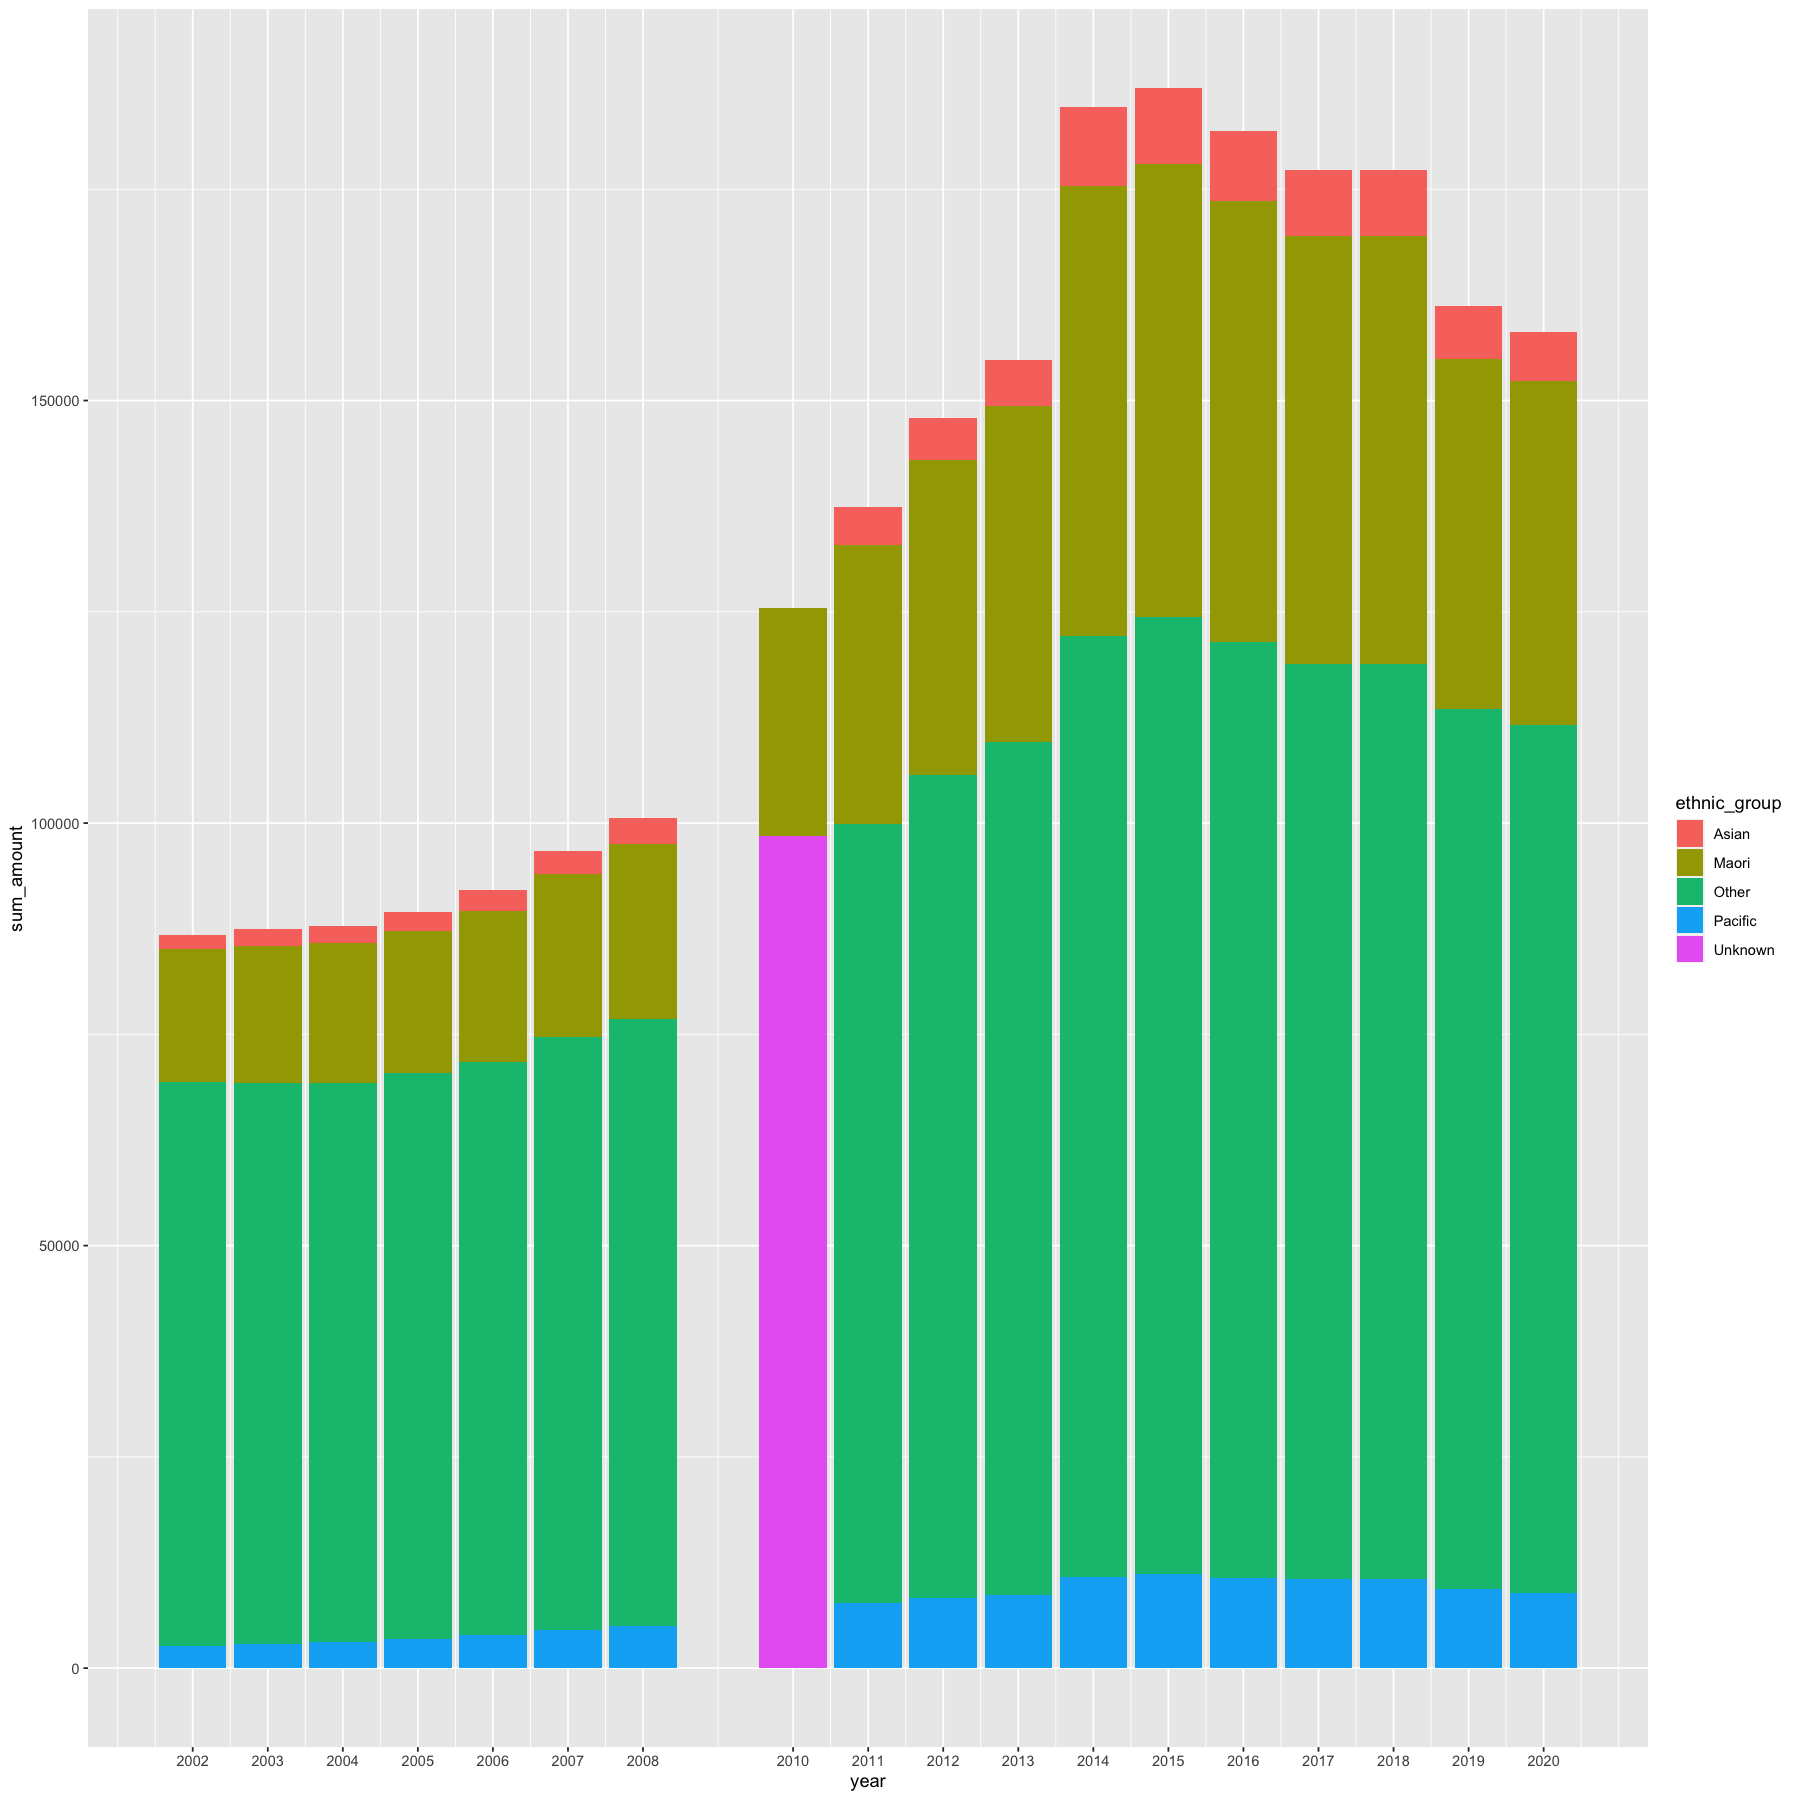

In [106]:
years <- full_clients_by_gender_ethnic_df %>% select(year) %>% distinct()
full_clients_by_gender_ethnic_df %>% #filter(gender=='Male') %>%
                                     group_by(year, ethnic_group) %>% 
                                     select(year, ethnic_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=ethnic_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year)

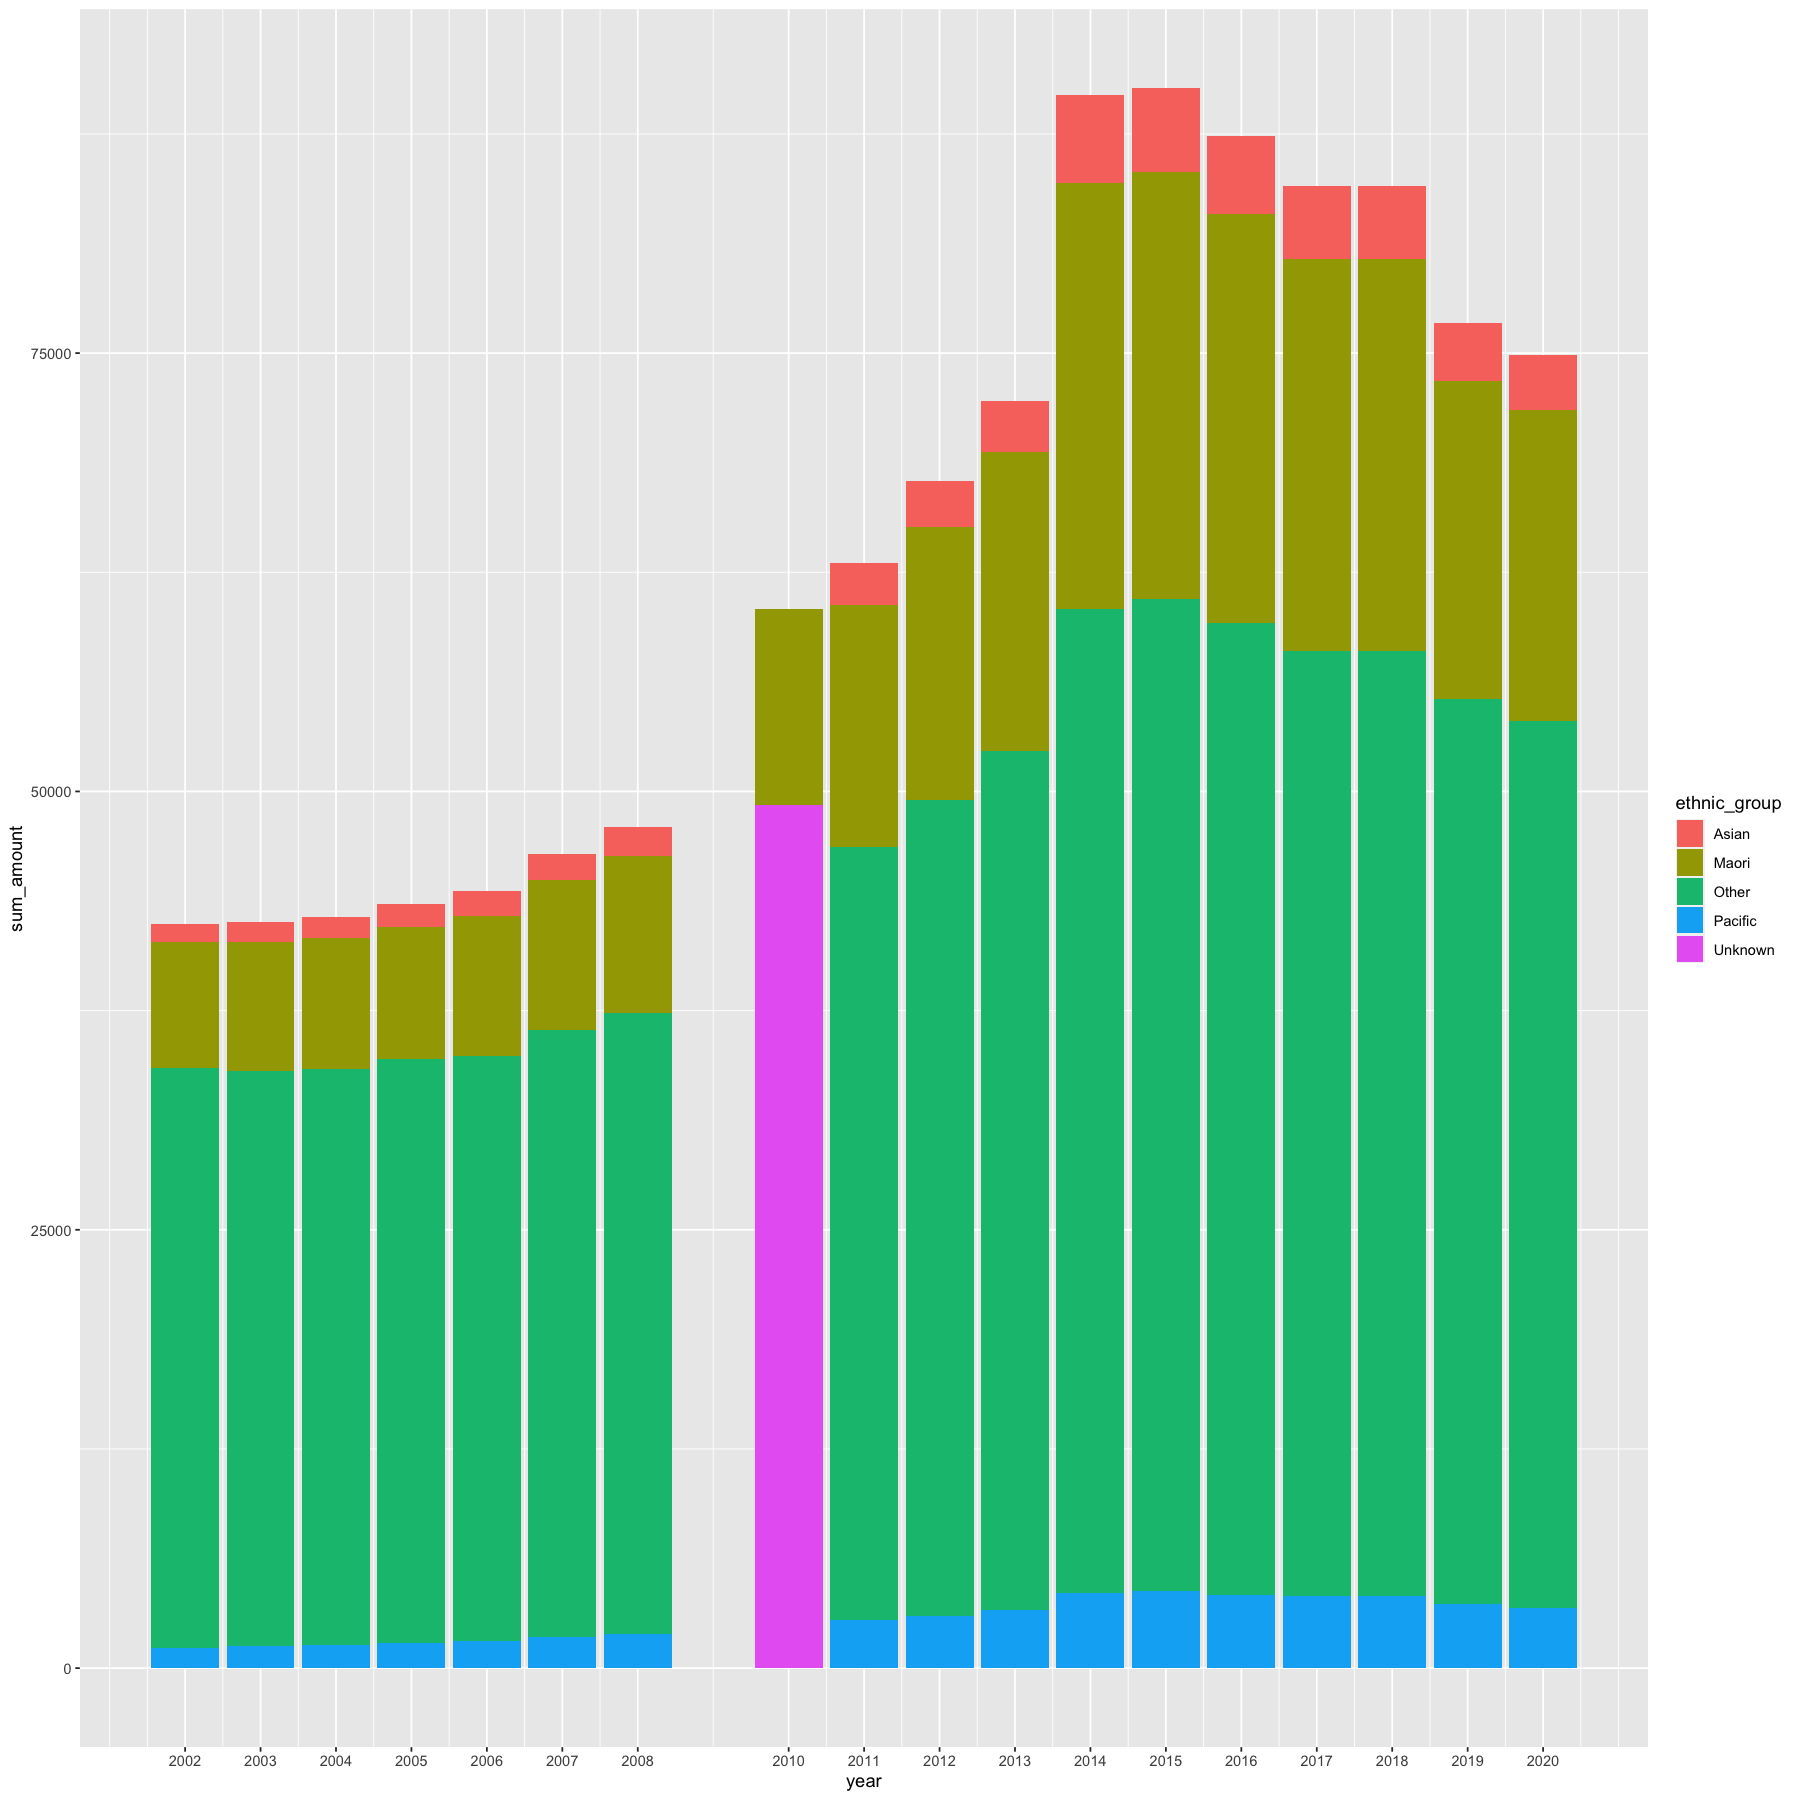

In [107]:
full_clients_by_gender_ethnic_df %>% filter(gender=='Female') %>%
                                     group_by(year, ethnic_group) %>% 
                                     select(year, ethnic_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=ethnic_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year)

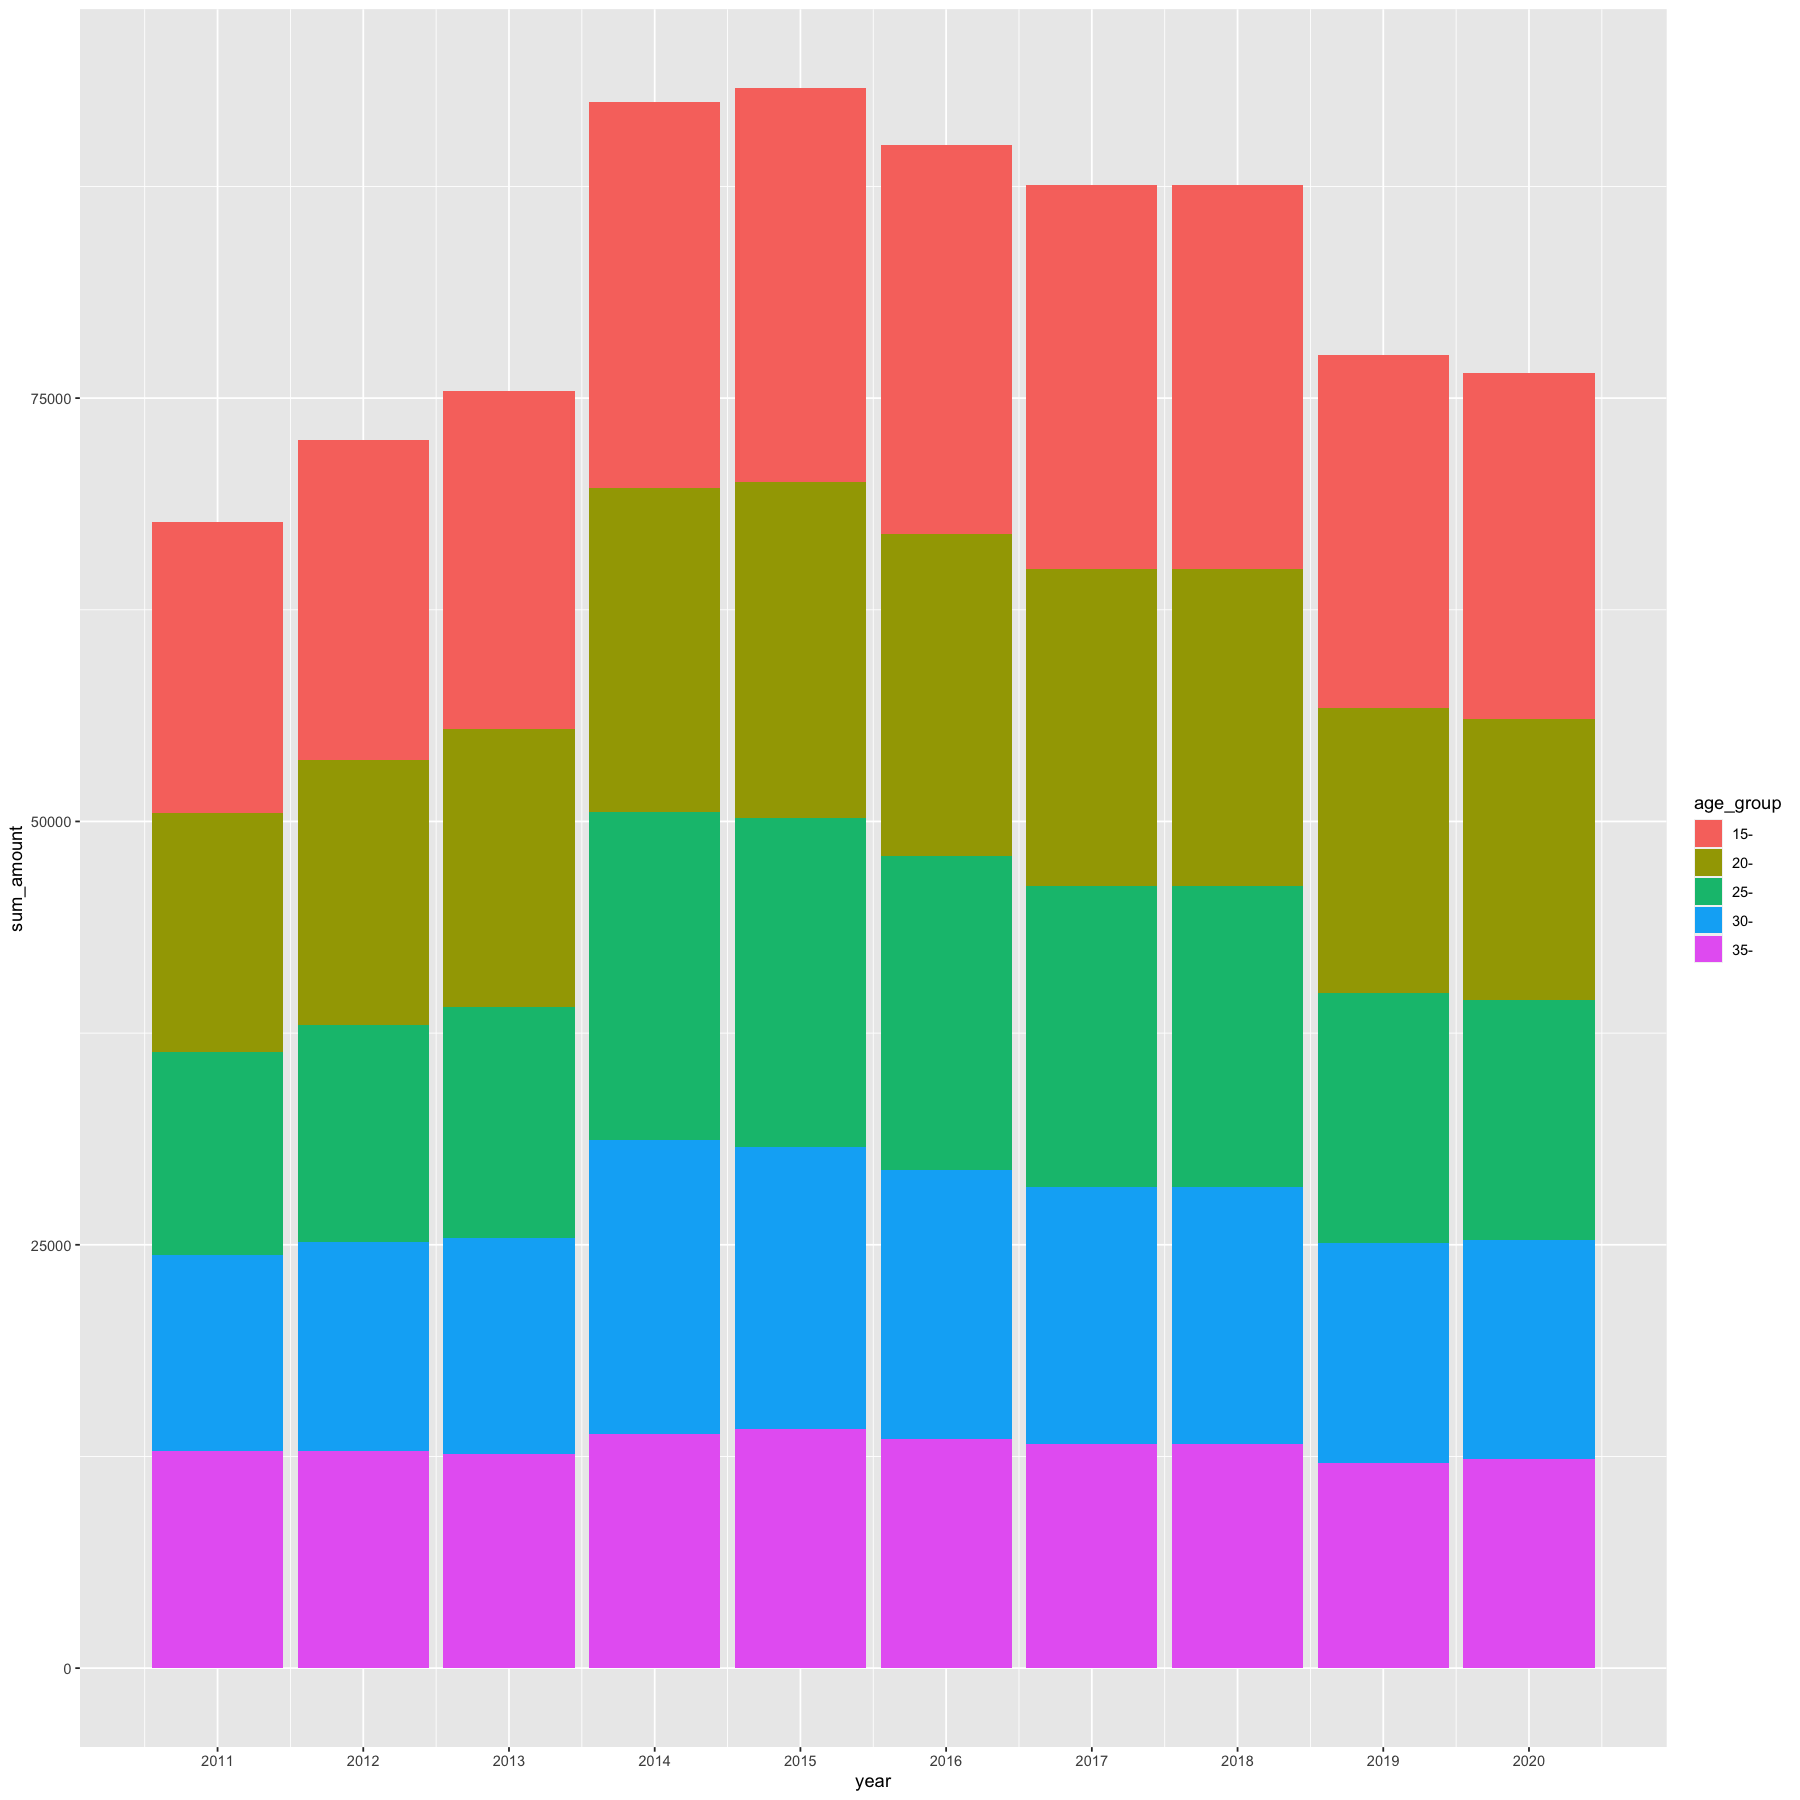

In [108]:
full_clients_by_gender_ethnic_df %>% filter(age_group %in% c('15-', '20-','25-', '30-', '35-')) %>%
                                     group_by(year, age_group) %>% 
                                     select(year, age_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=age_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year)

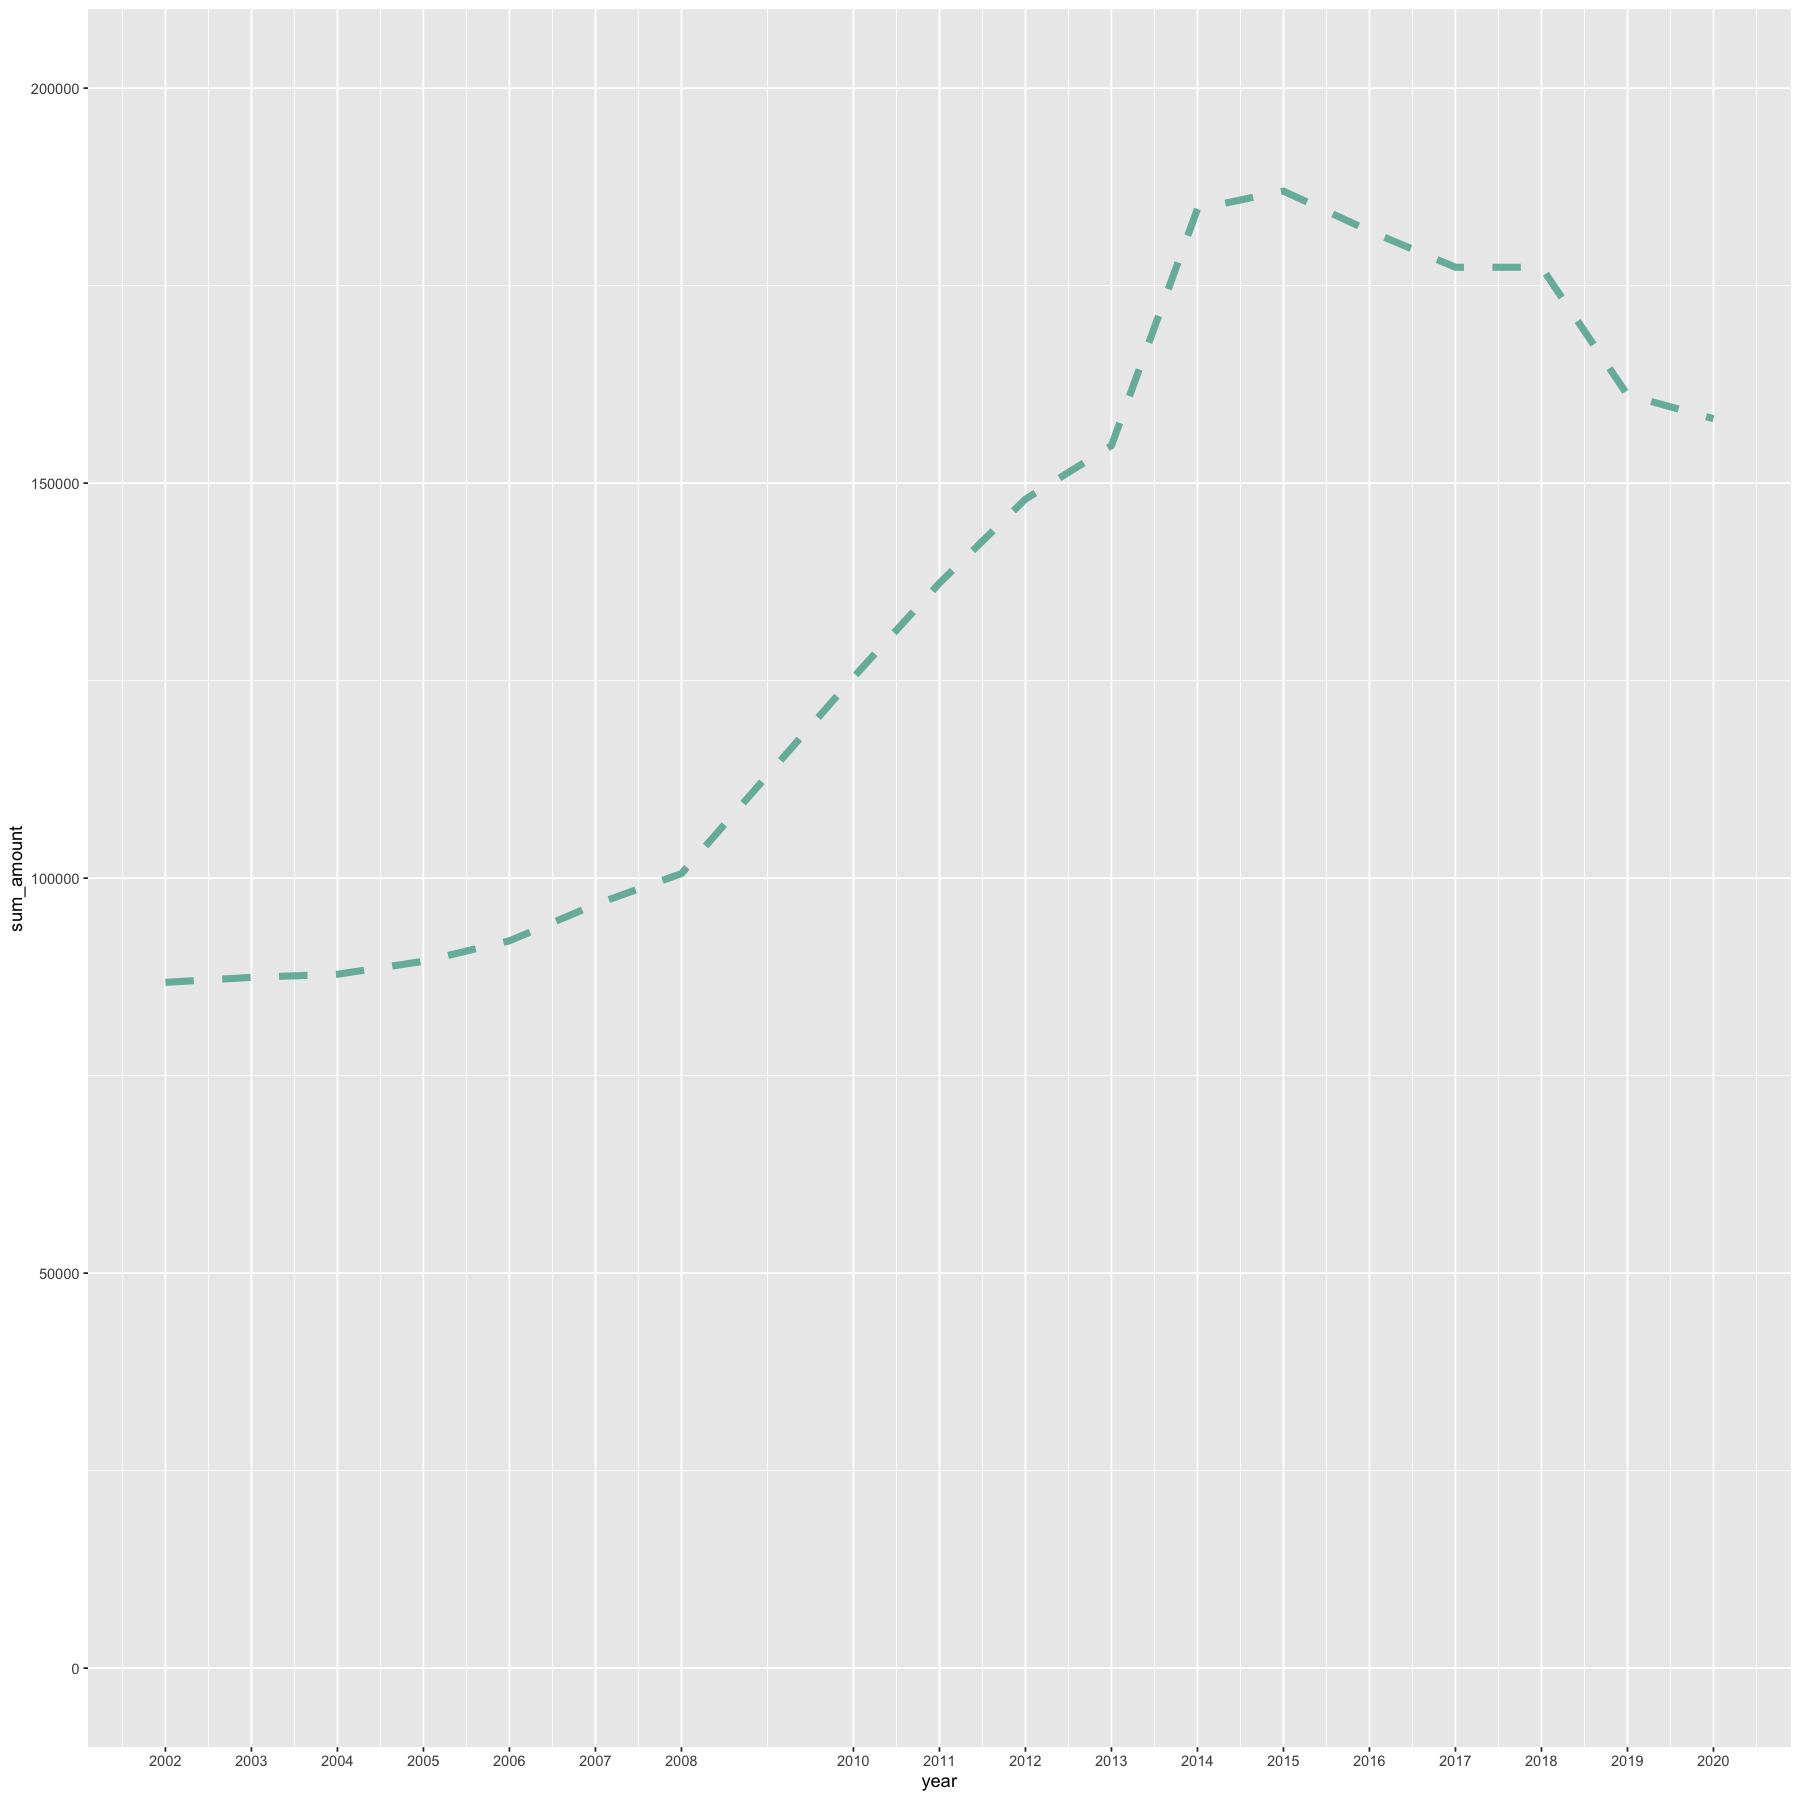

In [109]:
full_clients_by_gender_ethnic_df %>% group_by(year) %>% 
                                     select(year, amount) %>%
                                     summarise(sum_amount = sum(amount))  %>%
                                     ggplot(aes(x=year, y=sum_amount)) +
                                     scale_x_continuous(breaks=years$year) + 
                                     scale_y_continuous(limits=c(0, 200000)) + 
                                     geom_line(color="#69b3a2", size=2, alpha=0.9, linetype=2)


data sheet 17

In [530]:
#get data from sheet23 from one file
get_data_from_sheet23 <- function(file_yealy, year){
    
    client_ages_sheet23 <- file_yealy %>% read_excel(sheet = "table23", skip=2, range = cell_rows(4:4)) %>% colnames()
    client_team_type_col_names_sheet23 <- c('Team_type', 'Sex', 'total', client_ages_sheet23)

    #get df of sheet23
    client_team_type_sheet23 <- file_yealy %>% read_excel(sheet = "table23", skip=2, range='A4:U43')
    colnames(client_team_type_sheet23) <- client_team_type_col_names_sheet23

    #get num of row
    n_row_sheet23 <- nrow(client_team_type_sheet23)

    #set all na values with activity type 
    for (row_num in 1:n_row_sheet23){
        if(client_team_type_sheet23$Team_type[[row_num]] %>% is.na()){
            client_team_type_sheet23$Team_type[[row_num]] = client_team_type_sheet23$Team_type[[row_num - 1]]
            }
    }
    
    #long formate
    client_team_type_sheet23_long <- client_team_type_sheet23 %>% 
                                    gather('age_group', 'num_client', -c(Team_type,Sex,total)) %>% 
                                    arrange(Team_type, age_group)  
    
    #set all row with year
    client_team_type_sheet23_long <- client_team_type_sheet23_long %>% mutate('year_num' = year)
    
    return(client_team_type_sheet23_long)
}

#get all year sheet 23 data
get_all_year_client_team_type_df <- function(){
    
    result <- data.frame(Team_type=character(),
                         Sex=character(), 
                          total=character(),
                          age_group=character(),
                          num_client=character(),
                        year_num =character()) 
    
    for (i in 1:nrow(file_metadata_df)){ 
        row <- file_metadata_df[i,]
        result <- result %>% rbind(get_data_from_sheet23(row$file_name, row$year))
    }
    return(result) 
}

get_all_year_client_team_type_df() %>% tail()

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3



ERROR: Error: Sheet 'table23' not found


In [525]:
normalize_2002_2008_column_names <- function(columns){
    columns <- str_replace_all(columns, "Capital & Coast", "Capital and Coast")
    columns <- str_replace_all(columns, "MidCentral", "Mid Central")
    columns <- str_replace_all(columns, "Midcentral", "Mid Central")
    columns <- str_replace_all(columns, "Hutt Valley", "Hutt")
    columns <- str_replace_all(columns, "Southern", "Southland")
    columns <- stri_trans_general(columns, "Latin-ASCII")
    columns <- str_replace_all(columns, "unknown domicile", "Unknown")
    columns <- str_replace_all(columns, "Unknown domicile", "Unknown")
    return(columns)
}

normalize_2011_ownwards_column_names <- function(columns) {
    columns <- gsub("NA", "", columns)
    columns <- gsub("\r\n", " ", columns)
    columns <- str_replace_all(columns, "[[:punct:]]", "")
    columns <- str_replace_all(columns, "[[:number:]]", "")
    columns <- str_replace_all(columns, "MidCentral", "Mid Central")
    columns <- str_replace_all(columns, "Hutt Valley", "Hutt")
    columns <- str_replace_all(columns, "Southern", "Southland")
    columns <- str_replace_all(columns, "Capital  Coast", "Capital and Coast")
    columns <- stri_trans_general(columns, "Latin-ASCII")
    columns <- trimws(columns)    
    return(columns)
    
}

get_2002_to_2008_dhb_data <- function(file, sheet, range, year){
    dhb_df <- file %>% read_excel(sheet=sheet, range=range)
    colnames(dhb_df)[1] <- 'dhb'
    dhb_df <- dhb_df %>% mutate(dhb=gsub(" District Health Board", "", dhb))
    colnames(dhb_df) <- colnames(dhb_df) %>% normalize_2002_2008_column_names()
    dhb_df <- dhb_df %>% mutate(year=year)
    return(dhb_df)
}

get_2010_dhb_data <- function(filename, sheet, range){
    dhb_df <- filename %>% read_excel(sheet=sheet, range=range) %>% select(-Rate) 
    colnames(dhb_df)[1] <- 'dhb'    
    colnames(dhb_df)[2] <- 'amount'
    dhb_df <- dhb_df %>% mutate(origin=dhb) %>% 
                         pivot_wider(names_from=origin, values_from=amount, values_fill=0) %>%
                         mutate(year=2010)
    colnames(dhb_df) <- normalize_2002_2008_column_names(colnames(dhb_df))
    return(dhb_df)
}


get_2011_onwards_dhb_data <- function(file, sheet, header, range, year){
    header <- file %>% read_excel(sheet=sheet, range=header)
    dhb_df <- file %>% read_excel(sheet=sheet,range=range)
    if (any(is.na(dhb_df[1,]))){
        colnames(dhb_df) <- paste(colnames(header), as.character(dhb_df[1,]))
        dhb_df<- dhb_df[-1,]
    } else if('...1' %in% colnames(dhb_df[1,])){
        colnames(dhb_df) <- paste(colnames(header), colnames(dhb_df[1,]))
    }else{
        colnames(dhb_df) <- colnames(header)
    }
    colnames(dhb_df)[1] <- 'dhb'
    colnames(dhb_df) <- colnames(dhb_df) %>% normalize_2011_ownwards_column_names()
    dhb_df <- dhb_df %>% mutate(year=year)
    if (!('Otago' %in% colnames(dhb_df))){
        dhb_df <- dhb_df %>% mutate(Otago=0)
    }
    return(dhb_df)
}

all_data_dhb <- get_2002_to_2008_dhb_data('mental_health2002.xls', "A20", 'A5:W26', 2002) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2003.xls', "A20", 'A5:W26', 2003)) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2004.xls', "A20", 'A5:W26', 2004)) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2005.xls', "A20", 'A5:W26', 2005)) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2006.xls', "20A", 'A5:W26', 2006)) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2007.xls', "20B", 'A5:W26', 2007)) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2008.xls', "A20", 'A5:W26', 2008)) %>%
                rbind(get_2010_dhb_data('mental_health2010.xls', "T10 Nos Rates 0910 DHB",'A2:C24'))%>% 
                rbind(get_2011_onwards_dhb_data('mental_health2011.xlsx', 'Table12', 'A4:V4', 'A5:v25', 2011)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2012.xlsx', 'table12', 'A4:V4', 'A5:v25', 2012)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2013.xlsx', 'table12', 'A4:V4', 'A5:v25', 2013)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2014.xlsx', 'table12', 'A4:V4', 'A5:v24', 2014)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2015.xlsx', 'table12', 'A4:V4', 'A5:v24', 2015)) %>%
                rbind(get_2011_onwards_dhb_data('mental_health2016.xlsx', 'table12', 'A4:V4', 'A5:v24', 2016)) %>%
                rbind(get_2011_onwards_dhb_data('mental_health2017.xlsx', 'table12', 'A4:V4', 'A5:v24', 2017)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2018.xlsx', 'table12', 'A4:V4', 'A5:v24', 2018)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2019.xlsx', 'table12', 'A4:V4', 'A4:v25', 2019)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2020.xlsx', 'table12', 'A4:V4', 'A4:v25', 2020))


all_data_dhb

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1

New names:
* `7` -> `7...9`
* `10` -> `10...10`
* `13` -> `13...11`
* `13` -> `13...12`
* `8` -> `8...13`
* ...

New names:
* `` -> ...1

New names:
* `9` -> `9...11`
* `14` -> `14...14`
* `2` -> `2...16`
* `9` -> `9...17`
* `2` -> `2...18`
* ...

New names:
* `` -> ...1

New names:
* `18` -> `18...7`
* `12` -> `12...10`
* `6` -> `6...11`
* `12` -> `12...12`
* `6` -> `6...13`
* ...

New names:
* `` -> ...1

New names:
* `2` -> `2...16`
* `2` -> `2...20`

New names:
* `` -> ...1

New names:
* `2` -> `2...16`
* `2` -> `2...20`



dhb,Northland,Waitemata,Auckland,Counties Manukau,Waikato,Lakes,Bay of Plenty,Tairawhiti,Taranaki,⋯,Hutt,Wairarapa,Nelson Marlborough,West Coast,Canterbury,South Canterbury,Otago,Southland,Unknown,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Northland,3130,112,91,67,32,12,14,1,3,⋯,12,0,6,4,8,2,8,3,7,2002
Waitemata,330,9065,3325,1649,186,55,109,15,55,⋯,40,9,29,4,58,8,29,22,59,2002
Auckland,67,613,5526,295,42,12,28,5,7,⋯,7,1,0,1,7,3,10,4,20,2002
Counties Manukau,62,125,457,3573,51,12,33,1,12,⋯,9,0,6,1,12,2,2,3,12,2002
Waikato,37,76,70,65,6545,197,262,17,97,⋯,20,2,8,1,17,3,5,4,4,2002
Lakes,11,15,23,20,61,2029,64,3,11,⋯,7,2,3,1,7,2,0,4,5,2002
Bay of Plenty,11,36,35,29,113,66,5167,11,10,⋯,12,0,5,3,8,0,10,7,2,2002
Tairawhiti,7,17,20,12,21,14,30,969,4,⋯,17,3,1,0,9,0,6,5,0,2002
Taranaki,4,14,16,17,33,2,11,1,3355,⋯,10,3,6,1,8,0,6,1,7,2002


In [526]:
all_data_dhb <- all_data_dhb %>% mutate(across(everything(), as.character))
longer_dhb_data <- all_data_dhb %>% pivot_longer(cols=-c('dhb', 'year'), names_to = "origin", values_to = "amount")
names(longer_dhb_data)[names(longer_dhb_data) == 'dhb'] <- "destination"
longer_dhb_data <- longer_dhb_data %>% select(origin, destination, amount, year)
longer_dhb_data <- longer_dhb_data %>% mutate(amount=as.integer(amount))



Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0xd”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0xd”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0xd”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0xd”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0xd”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0xd”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0xd”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0xd”
Warning message in grid.Call(C_t

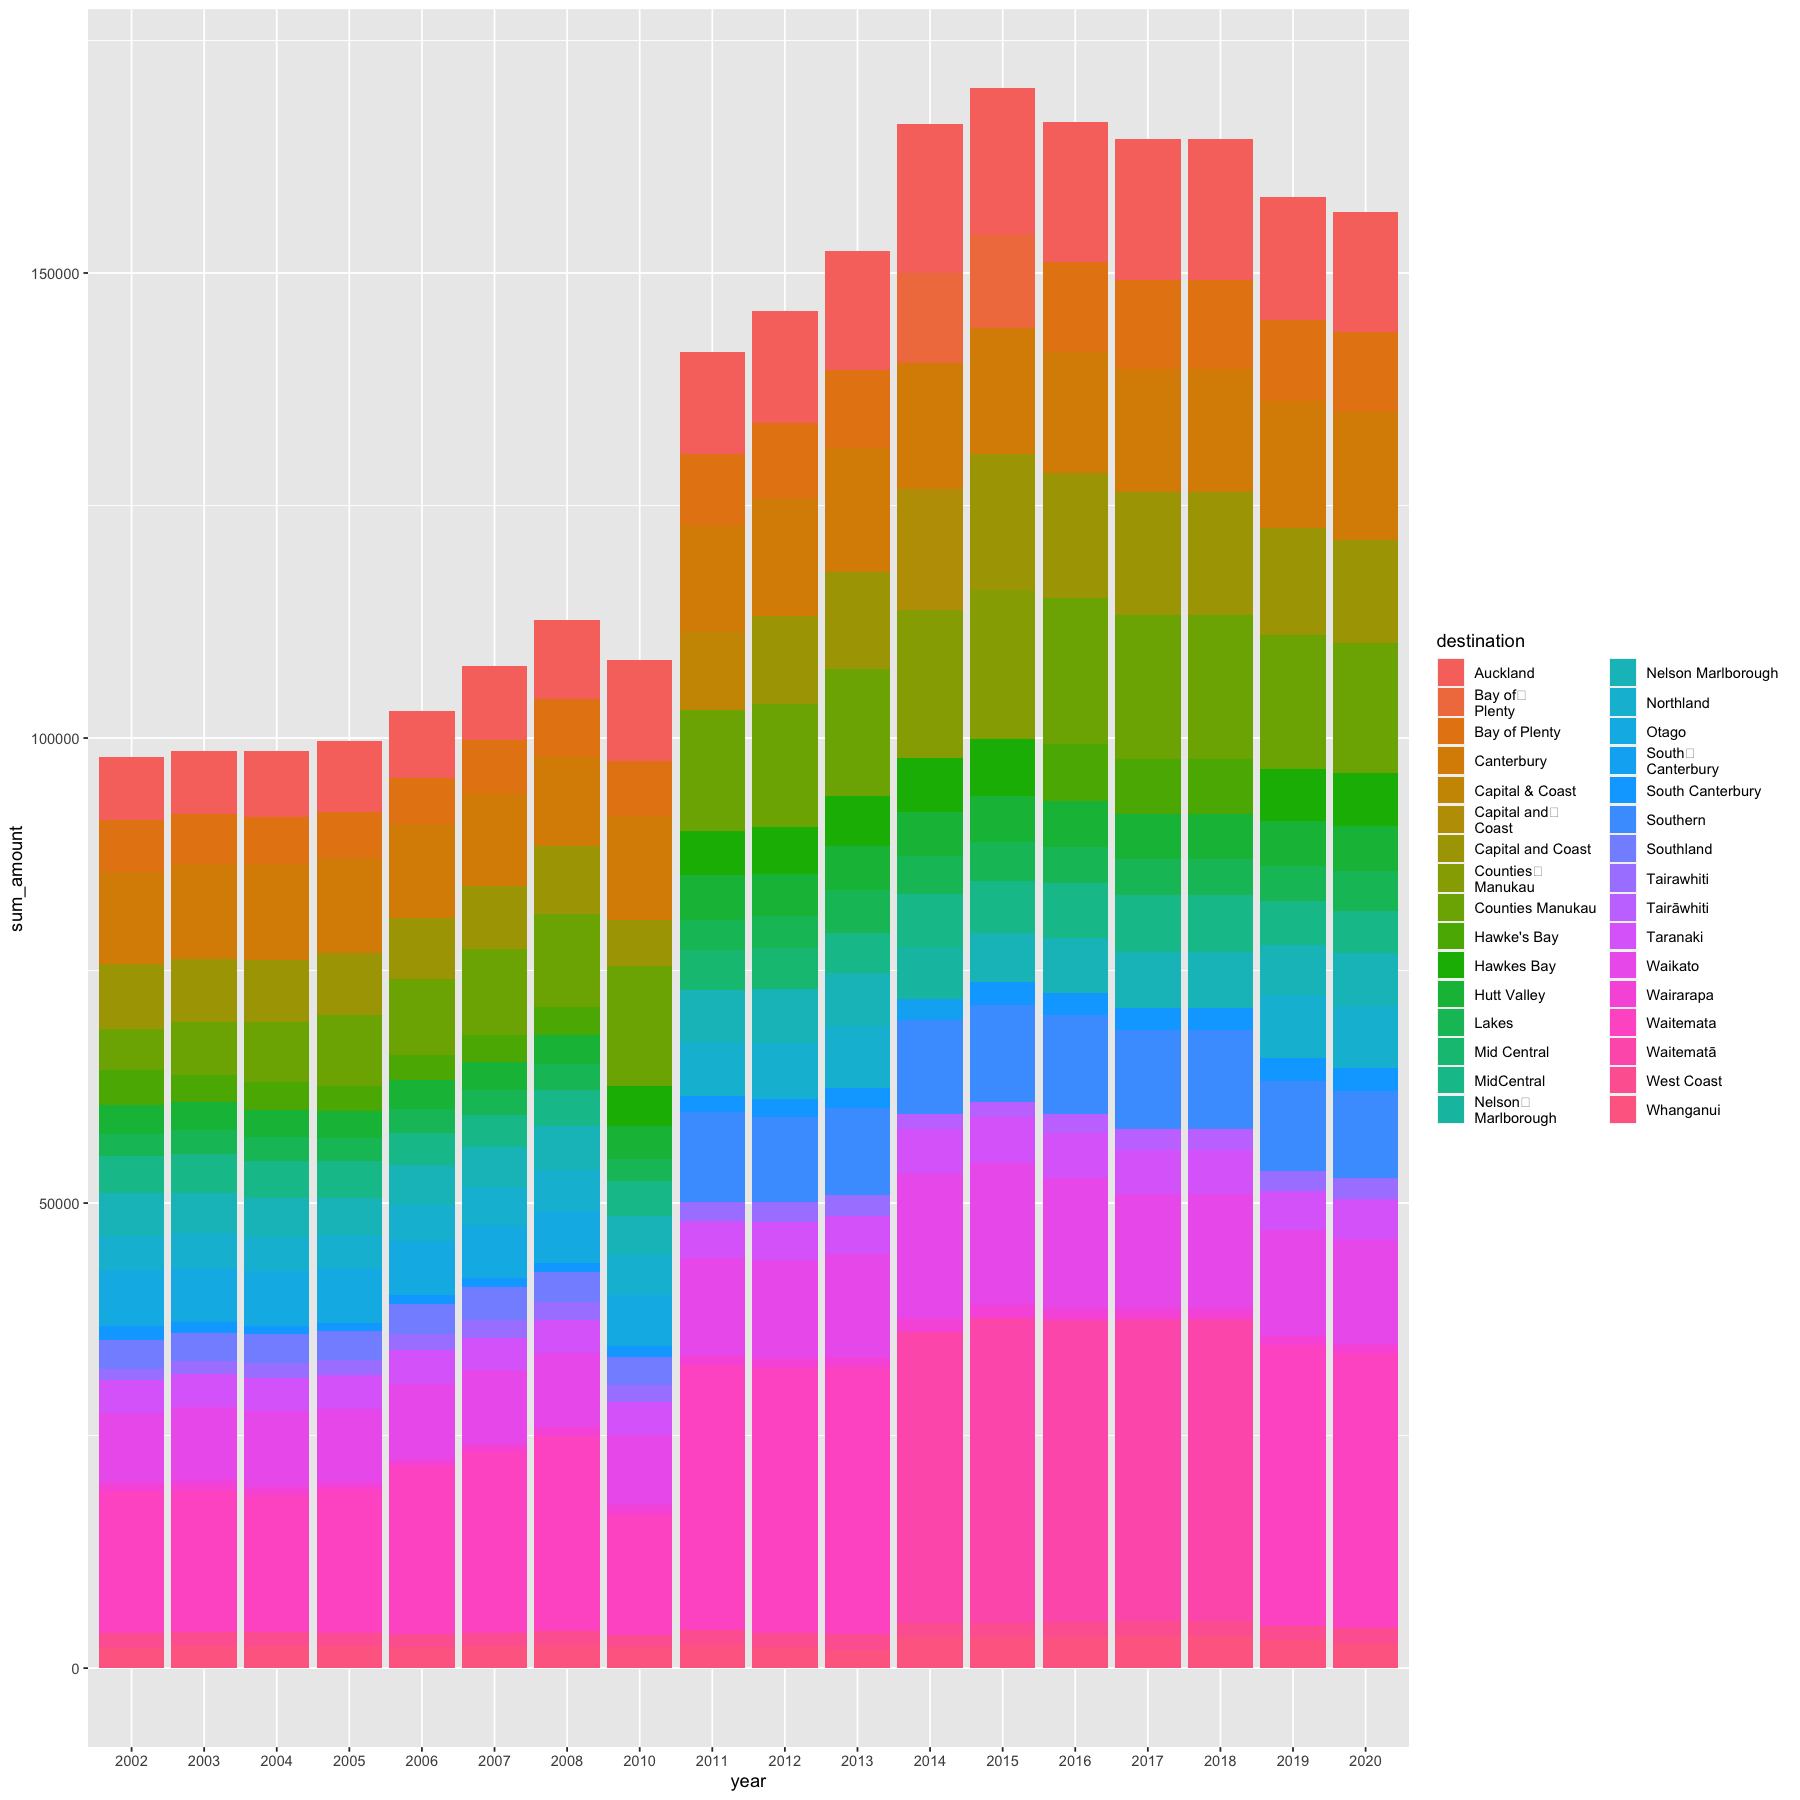

In [528]:
longer_dhb_data %>% filter(destination!='Unknown')%>% 
                    group_by(destination, year) %>%
                    select(destination, year,  amount) %>% 
                    summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                    ggplot(aes(fill=destination, y=sum_amount, x=year)) + 
                    geom_bar(position="stack", stat="identity")


In [746]:
get_service_data <- function(filename, sheet, range, year, cols=NULL){
   data <- filename %>% read_excel(sheet=sheet, range=range) 
   colnames(data)[1] <- 'activity'
   colnames(data)[2] <- 'gender'
   colnames(data)[3] <- 'Total'

   if (year == 2003){
       colnames(data)[4] <- '0-4'
   }
   colnames(data) <- gsub('-', '–', colnames(data)) # that took a long time.
   data <- data %>% mutate(activity = as.character(na_if(activity, '.'))) %>% 
             fill(activity, .direction = 'down') %>% 
             na.omit(gender) %>% 
             filter(gender!='Total') %>% 
             select(-Total) %>%
             mutate(year=year)
    
    if (!(missing(cols))){
        colnames(data) <- cols
    }
    return(data)
}

full_colnames <- colnames(get_service_data('mental_health2002.xls', "A9",  'B5:V131', 2002))

service_data <- get_service_data('mental_health2002.xls', "A15",  'B5:V93', 2002) %>%
                rbind(get_service_data('mental_health2003.xls', "A15",  'B5:V93', 2003)) %>% 
                rbind(get_service_data('mental_health2004.xls', "A15",  'B5:V93', 2004)) %>% 
                rbind(get_service_data('mental_health2005.xls', "A15",  'B5:V93', 2005)) %>% 
                rbind(get_service_data('mental_health2006.xls', "15A",  'B5:V93', 2006, full_colnames)) %>% 
                rbind(get_service_data('mental_health2007.xls', "15B",  'B5:V93', 2007, full_colnames)) %>% 
                rbind(get_service_data('mental_health2008.xls', "A15",  'B5:V93', 2007, full_colnames)) %>%
                rbind(get_service_data('mental_health2008.xls', "A15",  'B5:V93', 2008, full_colnames)) %>%
                rbind(get_service_data('mental_health2011.xlsx', "Table23",  'A4:U73', 2011, full_colnames)) %>%
                rbind(get_service_data('mental_health2012.xlsx', "table23",  'A4:U73', 2012, full_colnames)) %>%
                rbind(get_service_data('mental_health2013.xlsx', "table23",  'A4:U73', 2013, full_colnames)) %>% 
                rbind(get_service_data('mental_health2014.xlsx', "table23",  'A4:U73', 2014, full_colnames)) %>% 
                rbind(get_service_data('mental_health2015.xlsx', "table23",  'A4:U73', 2015, full_colnames)) %>% 
                rbind(get_service_data('mental_health2016.xlsx', "table23",  'A3:U43', 2016, full_colnames)) %>% 
                rbind(get_service_data('mental_health2017.xlsx', "table23",  'A4:U73', 2017, full_colnames)) %>%
                rbind(get_service_data('mental_health2018.xlsx', "table23",  'A4:U73', 2018, full_colnames)) %>%
                rbind(get_service_data('mental_health2019.xlsx', "table23",  'A4:U73', 2019, full_colnames)) %>% 
                rbind(get_service_data('mental_health2020.xlsx', "table23",  'A4:U73', 2020, full_colnames)) 

service_data

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...5
* `` -> ...6
* `` -> ...7
* `` -> ...8
* `` -> ...9
* ...

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3



activity,gender,0–4,5–9,10–14,15–19,20–24,25–29,30–34,35–39,⋯,45–49,50–54,55–59,60–64,65–69,70–74,75–79,80–84,85+,year
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Inpatient team,Male,4,2,8,229,687,668,660,638,⋯,351,244,168,112,45,32,24,13,9,2002
Inpatient team,Female,5,0,8,203,379,443,522,562,⋯,365,280,217,144,63,32,30,13,9,2002
Community team,Male,15,98,270,1292,2411,2697,3025,3032,⋯,2111,1606,1050,793,384,280,198,119,69,2002
Community team,Female,14,36,316,1652,2413,2789,3427,3610,⋯,2494,2082,1477,1076,598,359,303,197,148,2002
Alcohol and drug team,Male,1,16,190,1002,1287,1562,1815,1754,⋯,846,419,222,114,63,35,14,4,3,2002
Alcohol and drug team,Female,0,11,116,498,596,888,1077,1028,⋯,463,248,147,55,35,19,13,6,3,2002
"Child, adolescent and family team",Male,393,2608,3703,1588,57,37,18,32,⋯,32,16,8,9,0,0,2,0,2,2002
"Child, adolescent and family team",Female,211,1063,1985,2078,123,79,106,100,⋯,43,21,14,13,2,2,2,0,0,2002
Forensic team,Male,0,0,20,298,544,571,572,504,⋯,227,112,78,35,17,12,7,0,0,2002


In [747]:
long_col_name <- service_data %>% select(ends_with("-"), ends_with('+')) %>% names()
service_data <- service_data %>% pivot_longer(!c(activity, gender, year), names_to="age_group", values_to="amount")
service_data

activity,gender,year,age_group,amount
<chr>,<chr>,<dbl>,<chr>,<chr>
Inpatient team,Male,2002,0–4,4
Inpatient team,Male,2002,5–9,2
Inpatient team,Male,2002,10–14,8
Inpatient team,Male,2002,15–19,229
Inpatient team,Male,2002,20–24,687
Inpatient team,Male,2002,25–29,668
Inpatient team,Male,2002,30–34,660
Inpatient team,Male,2002,35–39,638
Inpatient team,Male,2002,40–44,493


In [751]:
service_data <- service_data %>% filter(activity!='Total') %>% mutate(activity=tolower(activity))

service_data <- service_data %>% mutate(amount=as.integer(amount))
service_data

activity,gender,year,age_group,amount
<chr>,<chr>,<dbl>,<chr>,<int>
inpatient team,Male,2002,0–4,4
inpatient team,Male,2002,5–9,2
inpatient team,Male,2002,10–14,8
inpatient team,Male,2002,15–19,229
inpatient team,Male,2002,20–24,687
inpatient team,Male,2002,25–29,668
inpatient team,Male,2002,30–34,660
inpatient team,Male,2002,35–39,638
inpatient team,Male,2002,40–44,493


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'alcohol and drug kaupapa māori team' in 'mbcsToSbcs': dot substituted for <c4>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'alcohol and drug kaupapa māori team' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'alcohol and drug kaupapa māori team' in 'mbcsToSbcs': dot substituted for <c4>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'alcohol and drug kaupapa māori team' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'alcohol and drug kaupapa māori team' in 'mbcsToSbcs': dot substituted for <c4>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), 

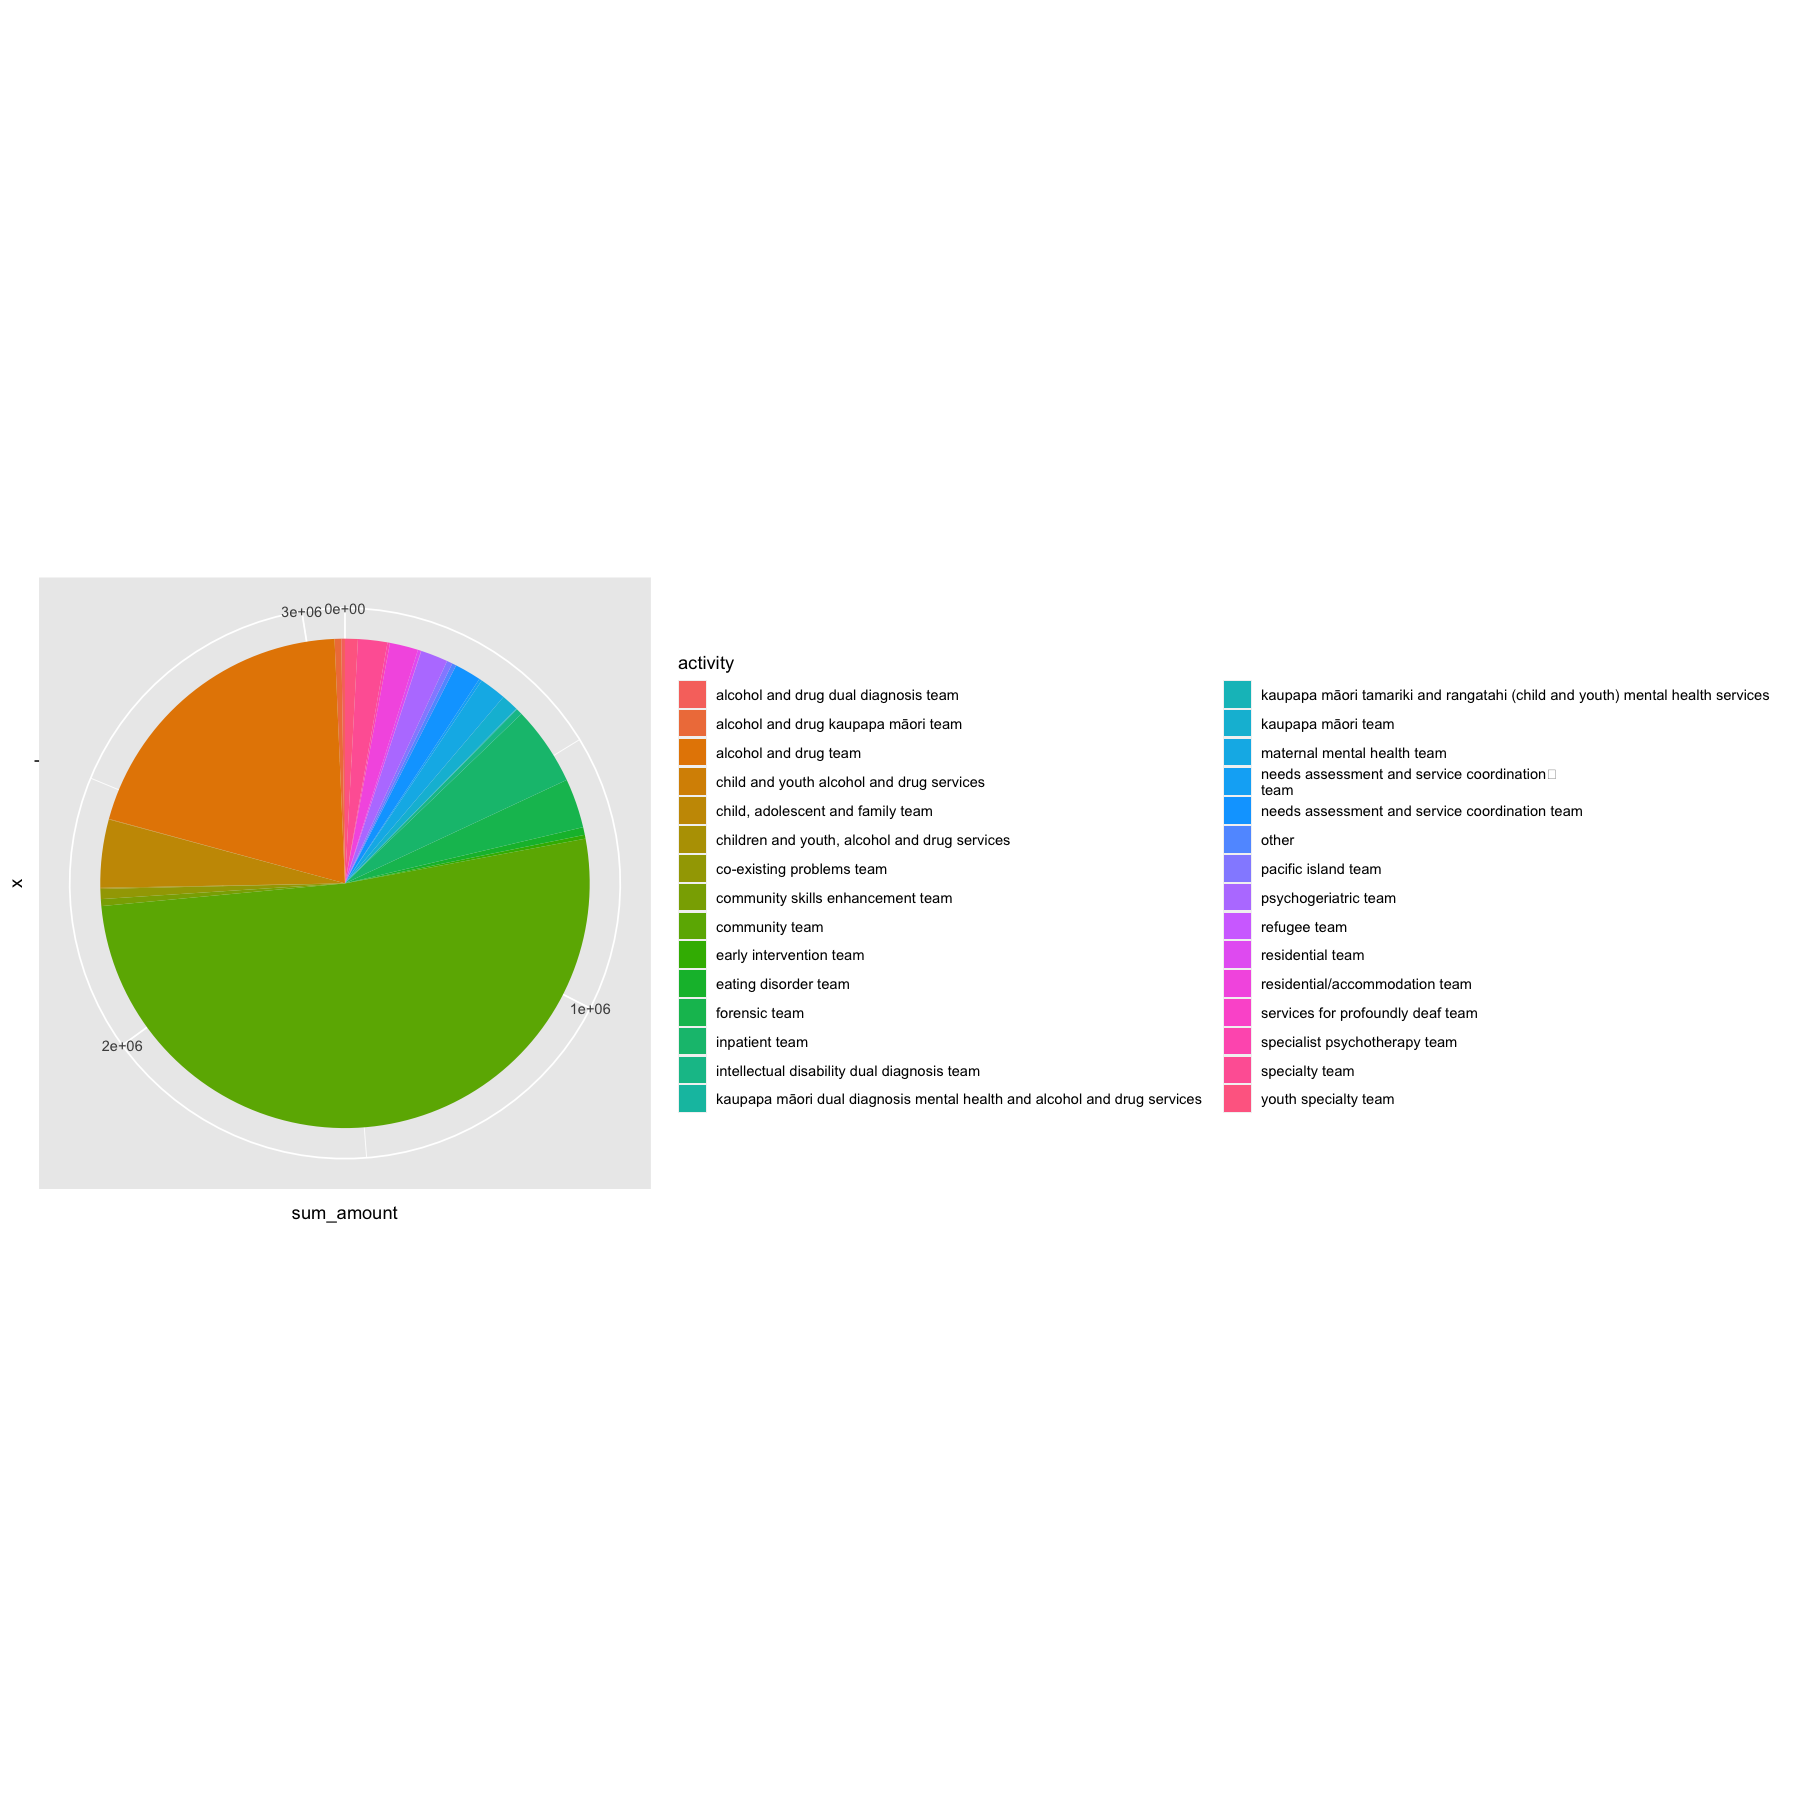

In [753]:
service_data %>%    group_by(activity) %>%
                    select(activity,amount) %>% 
                    summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                    ggplot(aes(fill=activity, y=sum_amount, x="")) + 
                    geom_bar(stat="identity") + coord_polar("y", start=0)

